### 1. Introduction

The purpose of this notebook is to demonstrate a Regression analysis on the *Car Price* data set for the purposes of the data innovation health check. The demonstration herein is encoded using R. The data set can be found and downloaded from (Kaggle)[bit.ly/dia-car-price-data-set]. To use this interactive notebook, download the data set as a CSV and input the file path and name of the downloaded CSV file in the `data_file_path` variable's definition below.

#### 1.1 Data Introduction

The Car Price data set contains 205 observations and 22 data columns, where each observation represents an individual car. 'Car price' is chosen as the response variable for the analysis and the covariates include a number of numeric and descriptive measures of cars, that are thought to have an effect on a car's price. These predictors include measures such as 'car make', 'cylinder number', and 'highway miles per gallon (MPG)'.

#### 1.2  Load and View the Data 

In [44]:
####Required Libraries &  Helper Functions #### 
# ## run install.packages("package_name", "second_package"...) for the libraries below that aren't currently installed on your machine
library(mlr)
library(psych)
library(RColorBrewer)
library(ggplot2)
library(caret)
library(reshape2)
library(car)
library(tidyr)
library(dplyr)
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)
library(tidyverse)
library(gdata)
library(readr)
library(tidyverse)
library(broom)
library(corrplot)


## helper function for visualisations: plots multiple plots with shared legend
grid_arrange_shared_legend <-
  function(...,
           ncol = length(list(...)),
           nrow = 1,
           position = c("bottom", "right")) {
    
    plots <- list(...)
    position <- match.arg(position)
    g <-
      ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
    legend <- g[[which(sapply(g, function(x)
      x$name) == "guide-box")]]
    lheight <- sum(legend$height)
    lwidth <- sum(legend$width)
    gl <- lapply(plots, function(x)
      x + theme(legend.position = "none"))
    gl <- c(gl, ncol = ncol, nrow = nrow)
    
    combined <- switch(
      position,
      "bottom" = arrangeGrob(
        do.call(arrangeGrob, gl),
        legend,
        ncol = 1,
        heights = unit.c(unit(1, "npc") - lheight, lheight)
      ),
      "right" = arrangeGrob(
        do.call(arrangeGrob, gl),
        legend,
        ncol = 2,
        widths = unit.c(unit(1, "npc") - lwidth, lwidth)
      )
    )
    
    grid.newpage()
    grid.draw(combined)
    
    # return gtable invisibly
    invisible(combined)
    
  }

# input file path below
data_file_path = 'data_file_path_here/name_of_file.csv'

# read in the data as defines all data variables that are "strings" as FACTORS (i.e. a categorical data type in R)
df = read.csv(data_file_path, header = TRUE, 
         stringsAsFactors = TRUE, na.strings = "?")

# remove ID columns
df = df[,-c(1:2)] 

#check data structure for issues
print(str(df))



'data.frame':	205 obs. of  24 variables:
 $ CarName         : Factor w/ 147 levels "alfa-romero giulia",..: 1 3 2 4 5 9 5 7 6 8 ...
 $ fueltype        : Factor w/ 2 levels "diesel","gas": 2 2 2 2 2 2 2 2 2 2 ...
 $ aspiration      : Factor w/ 2 levels "std","turbo": 1 1 1 1 1 1 1 1 2 2 ...
 $ doornumber      : int  2 2 2 4 4 2 4 4 4 2 ...
 $ carbody         : Factor w/ 5 levels "convertible",..: 1 1 3 4 4 4 4 5 4 3 ...
 $ drivewheel      : Factor w/ 3 levels "4wd","fwd","rwd": 3 3 3 2 1 2 2 2 2 1 ...
 $ enginelocation  : Factor w/ 2 levels "front","rear": 1 1 1 1 1 1 1 1 1 1 ...
 $ wheelbase       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ carlength       : num  169 169 171 177 177 ...
 $ carwidth        : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 67.9 ...
 $ carheight       : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 52 ...
 $ curbweight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 3053 ...
 $ enginetype      : Factor w/ 7 levels "dohc","dohcv",..: 1 1 6 4 4 4 

In [68]:
# view the data frame 
head(df)

CarName  fueltype aspiration carbody      drivewheel wheelbase carlength
1 above_10 gas      std        convertibles rwd        88.6      168.8    
2 above_10 gas      std        convertibles rwd        88.6      168.8    
3 above_10 gas      std        hatchback    rwd        94.5      171.2    
4 above_10 gas      std        sedan        fwd        99.8      176.6    
5 above_10 gas      std        sedan        4wd        99.4      176.6    
6 above_10 gas      std        sedan        fwd        99.8      177.3    
  carwidth curbweight enginetype cylindernumber enginesize fuelsystem boreratio
1 64.1     2548       dohc       4              130        mpfi       3.47     
2 64.1     2548       dohc       4              130        mpfi       3.47     
3 65.5     2823       ohcv       five_and_six   152        mpfi       2.68     
4 66.2     2337       ohc        4              109        mpfi       3.19     
5 66.4     2824       ohc        five_and_six   136        mpfi       3.19     
6 66.3     2507       ohc        five_and_six   136        mpfi       3.19     
  horsepower citympg highwaympg log_price
1 111        21      27         9.510075 
2 111        21      27         9.711116 
3 154        19      26         9.711116 
4 102        24      30         9.543235 
5 115        18      22         9.767095 
6 110        19      25         9.632335

### 2. Data Cleaning 

The Car Price data set requires a small amount of data cleaning and transformation. The `Car Name` contains the make and model as one string. For example, ` Volkswagen Passat`. We want to generalise these observations such that the string just contains the car make. Below we extract the car make from the `Car Name` variable and delete the make. Using our above example, ` Volkswagen Passat` then becomes `Volkswagen`.

In [46]:
# we can see that the column `CarName` is a string of both make and model and as such the column as a factor has many levels. We will modify the string so it only contains the car make
df = separate(df, CarName, "CarName")

#redefine as FACTOR type
df["CarName"] <- lapply(df["CarName"] , factor)

# inspect new variable with levels() function which prints the classes of the categorical variable
levels(df$CarName)



[1] "alfa"       "audi"       "bmw"        "buick"      "chevrolet" 
 [6] "dodge"      "honda"      "isuzu"      "jaguar"     "maxda"     
[11] "mazda"      "mercury"    "mitsubishi" "nissan"     "Nissan"    
[16] "peugeot"    "plymouth"   "porcshce"   "porsche"    "renault"   
[21] "saab"       "subaru"     "toyota"     "toyouta"    "vokswagen" 
[26] "volkswagen" "volvo"      "vw"

After examining the new variable, we find that various spellings of the same car make result in separate levels in the`Car Name` variable for the same car make. For a given car make with various spellings, we collapse the resulting levels into one common level. This reduces the number of levels in `Car Name` from 28 levels to 22 levels, each with a unique car make.

In [47]:
# collapse various spellings for car make into one consistent class label

df$CarName <- fct_collapse(df$CarName,
                              "nissan" = c("Nissan", "nissan"),
)

df$CarName <- fct_collapse(df$CarName,
                           "mazda" = c("mazda", "maxda"),
)

df$CarName <- fct_collapse(df$CarName,
                           "volkswagen" = c("vokswagen", "volkswagen", "vw"),
)

df$CarName <- fct_collapse(df$CarName,
                           "porsche" = c("porcshce", "porsche"),
)

df$CarName <- fct_collapse(df$CarName,
                           "toyota" = c("toyota", "toyouta"),
)

# review new levels
levels(df$CarName)

[1] "alfa"       "audi"       "bmw"        "buick"      "chevrolet" 
 [6] "dodge"      "honda"      "isuzu"      "jaguar"     "mazda"     
[11] "mercury"    "mitsubishi" "nissan"     "peugeot"    "plymouth"  
[16] "porsche"    "renault"    "saab"       "subaru"     "toyota"    
[21] "volkswagen" "volvo"

### 3.  Data Wrangling

#### 3.1 Data Transformation

##### 3.1.1 Continuous Data Transformation

We perform a log transformation on `car price` so it is on a similar scale relative to the other measures within the data set. This can aid in visualisations and improve model accuracy by remedying data skewness. However, transformations can make model interpretations difficult. The model results can back-transformed onto the familiar linear scale to fix this.
 

In [48]:
df$log_price = log(df$price)

# drop price column
df = df[, -24]

##### 3.1.2 Categorical Variable Transformation

There are many categorical variables within the dataset. Categorical variables (CVs) are any variables that take on a limited set of values. Here, these include numeric values such as `door number` and strings such as `engine type`, `car make` and `body type`. There are several considerations to make when including categorical variables within a regression model.

One consideration is to ensure CV are defined correctly. We do this by first making sure all are truly defined as CVs, and then as ensure they are of the correct sub-type of CV. They can either be nominal, which means there is no inherent rank or order in the levels of the variable, or *ordinal* where there is a natural ordering such as size or sequence. Here, `door number` and `cylinder number` are *ordinal* CVs, the rest are *nominal*. For example, for `body type` there is no inherent ordering that makes convertibles larger/smaller or come before/after any other car body types.

Below we define the two numeric CVs that are incorrectly defined as continuous variables by *R*. This is common with numeric CVs. We also ensure that `door number` and `cylinder number` are defined as ordinal CVs using the `ordered` assignment, since `factors` in *R* are defined as nominal CVs. 

In [49]:
# define the numeric categorical variables as FACTORS-- R only defined STRINGS as factors 

df["doornumber"] <- lapply(df["doornumber"] , factor)
df["cylindernumber"] <- lapply(df["cylindernumber"] , factor)

# ordinal categorical variables: doornumber cylindernumber
df["cylindernumber"] <- lapply(df["cylindernumber"] , ordered)
df["doornumber"] <- lapply(df["doornumber"] , ordered)

# review to make sure all categoricals are correctly defined 
str(df)

'data.frame':	205 obs. of  24 variables:
 $ CarName         : Factor w/ 22 levels "alfa","audi",..: 1 1 1 2 2 2 2 2 2 2 ...
 $ fueltype        : Factor w/ 2 levels "diesel","gas": 2 2 2 2 2 2 2 2 2 2 ...
 $ aspiration      : Factor w/ 2 levels "std","turbo": 1 1 1 1 1 1 1 1 2 2 ...
 $ doornumber      : Ord.factor w/ 2 levels "2"<"4": 1 1 1 2 2 1 2 2 2 1 ...
 $ carbody         : Factor w/ 5 levels "convertible",..: 1 1 3 4 4 4 4 5 4 3 ...
 $ drivewheel      : Factor w/ 3 levels "4wd","fwd","rwd": 3 3 3 2 1 2 2 2 2 1 ...
 $ enginelocation  : Factor w/ 2 levels "front","rear": 1 1 1 1 1 1 1 1 1 1 ...
 $ wheelbase       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ carlength       : num  169 169 171 177 177 ...
 $ carwidth        : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 67.9 ...
 $ carheight       : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 52 ...
 $ curbweight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 3053 ...
 $ enginetype      : Factor w/ 7 levels "dohc","dohc

Often categorical data variables have a large number of possible values or *classes*. When a categorical variable has many classes, it can lead to an uneven distribution of observations in each class and often results in *rare classes* that contain a small percentage of the total observations. 

This is the case in the *Car Price* data set. Four of the CVs have more than 7 levels, and 'Car Name' variable has a total of 22 classes representing 22 different car makes. Frequency plots of these variables show that there are rare classes which contained less than 1% of the observations, while one class contained the majority.

We seek to reduce the CVs with high number of levels. Here, `carbody`, `enginetype`, `CarName`, `cylinder number` and ` fuel system` all have greater than 4 classes. We will reduce the number of classes by consolidating the category classes that have similar relationships with price.

To aid in class consolidation, we create frequency plots to visualise the number of observations in each class and boxplots of the data distribution of  `log_price` in each class, for each CV with a total number of classes above four. We also run *t-tests* to compare the price distribution between the classes we find visually 'similar', to confirm that they could be consolidated. 

The t-test will determine if the car price observations from two separate classes come from similar distributions, which is indicated by a *p-value* above 0.05. The first visual below shows that convertible and hardtop have a very similar `log_price` distribution, and the large p-value from the corresponding t-test confirms. This makes sense if we consider that often hardtops are considered a type of convertible.

Some CVs had rare classes (< 4% total observations) that did not have a distribution of `log_price` observations similar to any of the other classes within the CV. These rows corresponding to these classes are dropped from the dataset. 

[1] "T-test results for Convertible vs. Hardtop carbody classes"



	Welch Two Sample t-test

data:  a$log_price and b$log_price
t = 0.29919, df = 11.943, p-value = 0.7699
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6075749  0.8008747
sample estimates:
mean of x mean of y 
 9.890536  9.793886 


[1] "New Car Body Classes"


[1] "convertibles" "hatchback"    "sedan"        "wagon"

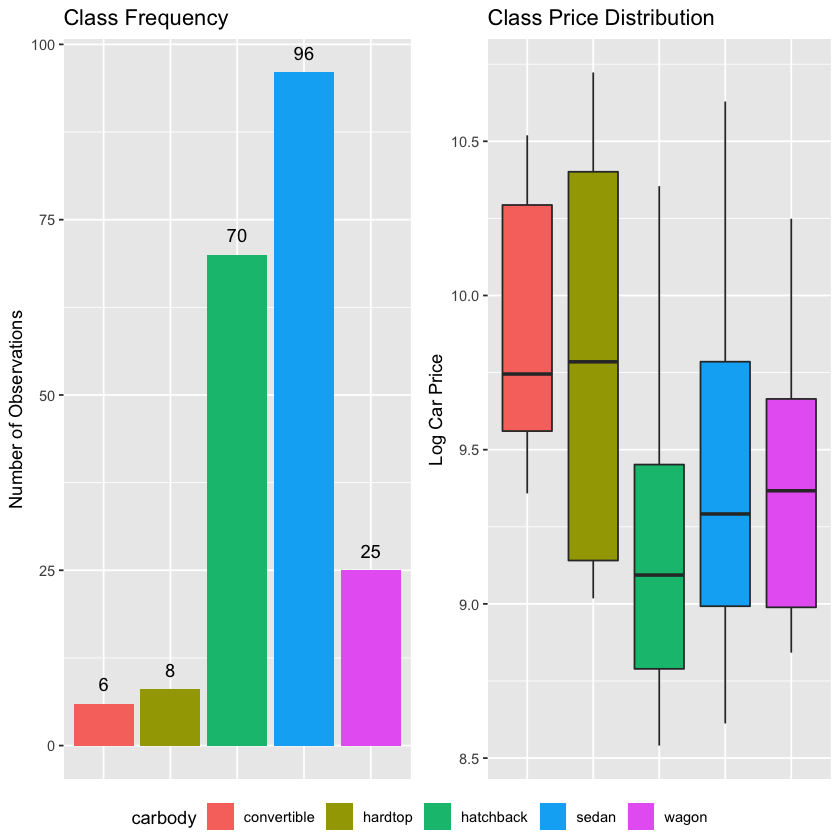

In [50]:
########## car body ################

# boxplots: visualise the distribution of car price in each plot and find the distributions that are similar
body_price = ggplot(df, aes(x = carbody , y = log_price, fill = carbody)) + geom_boxplot() +
  ylab('Log Car Price')+ 
  theme(legend.position="none", axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
    ggtitle(label = "Class Price Distribution")

# frequency plot: visualise the number of observations in each class
carbody_count = ggplot(df, 
       aes(x = carbody,  fill = carbody)) + 
  geom_bar(position = "stack") +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  ylab('Number of Observations')+ 
  theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
  ggtitle(label = "Class Frequency")

# plots both side by side
grid_arrange_shared_legend(carbody_count, body_price)

# isolate the observations for the first class of interest
a = filter(df, carbody == "convertible")

# isolate the observations for the second class of interest
b = filter(df, carbody == "hardtop")

# run a t-test on a and b observations 
print("T-test results for Convertible vs. Hardtop carbody classes")
t.test(a$log_price, b$log_price)

# consolidate the chosen classes
df$carbody <- fct_collapse(df$carbody,
                         convertibles = c("convertible", "hardtop"),
)

#review new levels
print("New Car Body Classes")
levels(df$carbody)



[1] "T-test results for Five vs. Six Cylinder Class"



	Welch Two Sample t-test

data:  a$log_price and b$log_price
t = -0.54885, df = 24.591, p-value = 0.5881
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2957555  0.1713746
sample estimates:
mean of x mean of y 
 9.945425 10.007616 


[1] "New Cylinder Number Classes"


[1] "2"            "4"            "8"            "five_and_six"

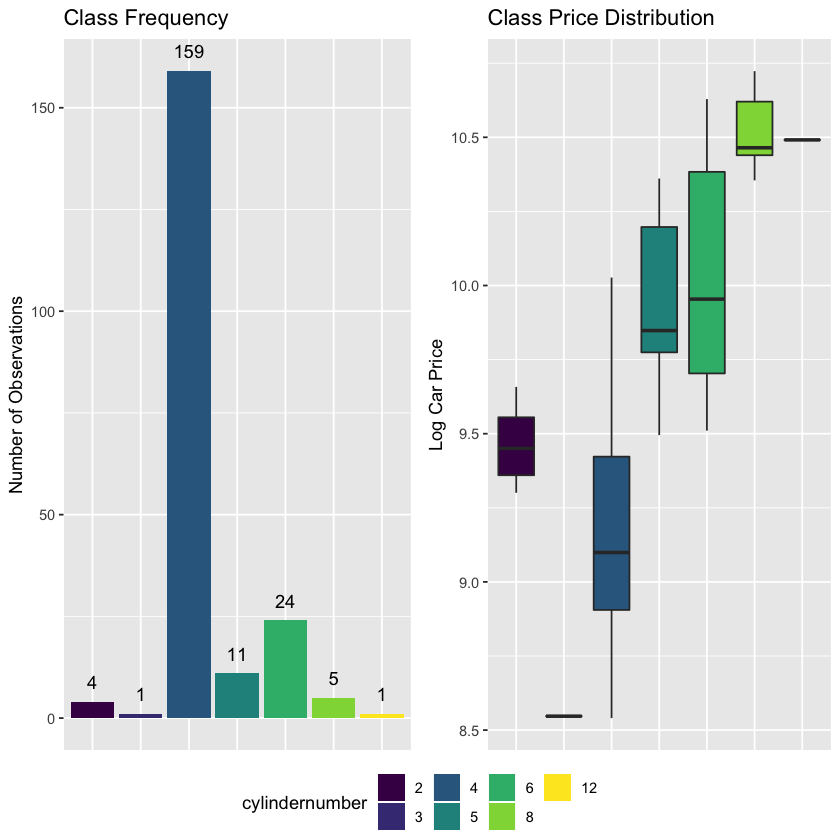

In [51]:

############ cylinder number ############

# boxplots: visualise the distribution of car price in each plot and find the distributions that are similar
cylin_price = ggplot(df, aes(x = cylindernumber , y = log_price, fill = cylindernumber)) + geom_boxplot()  +
  ylab('Log Car Price')+ 
  theme(legend.position="none", axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
    ggtitle(label = "Class Price Distribution")

# frequency plot: visualise the number of observations in each class
cylin_count = ggplot(df, aes(x = cylindernumber, fill= cylindernumber )) + 
  geom_bar(position = "stack") +
  geom_text(stat='count', aes(label=..count..), vjust=-1)+
  ylab('Number of Observations')+ 
  theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
  ggtitle(label = "Class Frequency")

# plots both side by side
grid_arrange_shared_legend(cylin_count, cylin_price)


# isolate the observations for the first classes of interest
a = filter(df, cylindernumber == 5)

# isolate the observations for the second classes of interest
b = filter(df, cylindernumber == 6)

# run a t-test on a and b observations 
print("T-test results for Five vs. Six Cylinder Class")
t.test(a$log_price, b$log_price)

# consolidate the chosen classes
df$cylindernumber <- fct_collapse(df$cylindernumber,
                           "five_and_six" = c("5", "6"),
)

# drop rare classes that can't be consolidated
df = df %>% filter(cylindernumber != 3, cylindernumber != 12)

# drop the now unused level labels from variable definition
df$cylindernumber = drop.levels(df$cylindernumber)

#review new levels
print("New Cylinder Number Classes")
levels(df$cylindernumber)




In [52]:
############ engine type ############

# boxplots: visualise the distribution of car price in each plot and find the distributions that are similar
enginetype_price = ggplot(df, aes(x = enginetype  , y = log_price, fill = enginetype )) + geom_boxplot()  +
  ylab('Log Car Price')+ 
  theme(legend.position="none", axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
    ggtitle(label = "Class Price Distribution")

# frequency plot: visualise the number of observations in each class
enginetype_count = ggplot(df, 
                     aes(x = enginetype, fill = enginetype)) + 
  geom_bar(position = "stack") +
  geom_text(stat='count', aes(label=..count..), vjust=-1)+
  ylab('Number of Observations')+ 
  theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
  ggtitle(label = "Class Frequency")

# plots both side by side
grid_arrange_shared_legend(enginetype_count, enginetype_price)

## consolidate  OHC and OHCF engine type classes

# isolate the observations for the first class of interest
a = filter(df, enginetype == "ohc")

# isolate the observations for the second class of interest
b = filter(df, enginetype == "ohcf")

# run a t-test on a and b observations 
print("T-test results for OHC vs OHCF engine types")
t.test(a$log_price, b$log_price)

# consolidate the chosen classes
df$enginetype <- fct_collapse(df$enginetype,
                                  "ohc" = c("ohc", "ohcf"),
)


## repeat for "dohc" and "l" engine classes

# isolate the observations for the first class of interest
a = filter(df, enginetype == "l")

# isolate the observations for the second class of interest
b = filter(df, enginetype == "dohc")

# run a t-test on a and b observations 
print("T-test results for DOHC and L engine types")
t.test(a$log_price, b$log_price)

# consolidate the chosen classes
df$enginetype <- fct_collapse(df$enginetype,
                              "ohc" = c("ohc", "rotor"),
)
# drop rare classes that can't be consolidated
df = df %>% filter(enginetype != "dohcv")

# drop the now unused level labels from variable definition
df$enginetype = drop.levels(df$enginetype)

#review new levels
print("New Engine Type Classes")
levels(df$enginetype)



[1] "T-test results for OHC vs OHCF engine types"



	Welch Two Sample t-test

data:  a$log_price and b$log_price
t = -0.41531, df = 15.508, p-value = 0.6836
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4200499  0.2827239
sample estimates:
mean of x mean of y 
 9.243439  9.312102 


[1] "T-test results for DOHC and L engine types"



	Welch Two Sample t-test

data:  a$log_price and b$log_price
t = -0.7344, df = 14.366, p-value = 0.4745
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3545403  0.1733512
sample estimates:
mean of x mean of y 
 9.637771  9.728366 


[1] "New Engine Type Classes"


[1] "dohc" "l"    "ohc"  "ohcv"

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange   gtable[arrange]
2 2 (2-2,1-1) arrange gtable[guide-box]
[1] "New Car Make Classes"


[1] "above_10" "above_20" "above_30" "below_10"

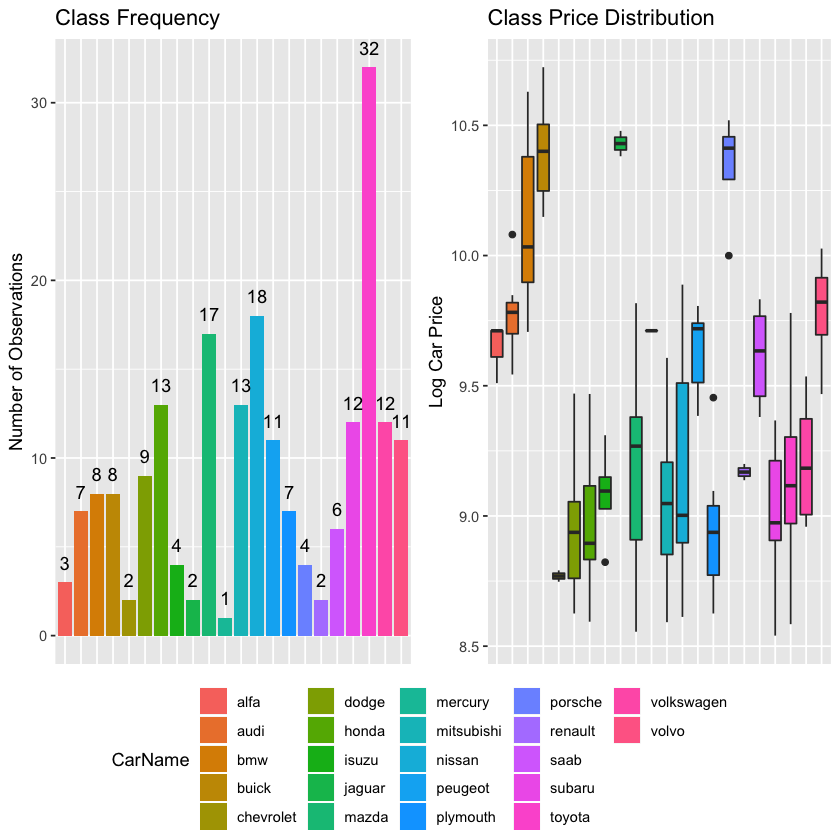

In [53]:
############ car make ############

# boxplots: visualise the distribution of car price in each plot and find the distributions that are similar
name_price = ggplot(df, aes(x = CarName  , y = log_price, fill = CarName )) + geom_boxplot()   +
  ylab('Log Car Price')+ 
  theme(legend.position="none", axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
    ggtitle(label = "Class Price Distribution")

# frequency plot: visualise the number of observations in each class

name_count = ggplot(df, aes(x = CarName, fill = CarName )) + 
  geom_bar(position = "stack") +
  geom_text(stat='count', aes(label=..count..), vjust=-1)+
  ylab('Number of Observations')+ 
  theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
  ggtitle(label = "Class Frequency")

# plots both side by side
print(grid_arrange_shared_legend(name_count, name_price))


# consolidate the classes 
df$CarName <- fct_collapse(df$CarName,
                           "above_30" = c("jaguar", "porsche", "buick"),
)


df$CarName <- fct_collapse(df$CarName,
                           "above_20" = c("bmw"),
)


df$CarName <- fct_collapse(df$CarName,
                           "above_10" = c("alfa","audi","mercury", "nissan",'peugeot','saab', 'volkswagen', 'volvo'),
)

df$CarName <- fct_collapse(df$CarName,
                           "below_10" = c("chevrolet", 'dodge', 'honda',"isuzu", "mazda",'mitsubishi', "plymouth", "renault", "subaru", "toyota"),
)


# drop the now unused level labels from variable definition
df$CarName = drop.levels(df$CarName)

#review new levels
print("New Car Make Classes")
levels(df$CarName)



[1] "New Fuel System Levels"


[1] "bbl"      "idi_4bbl" "mpfi"     "spdi"

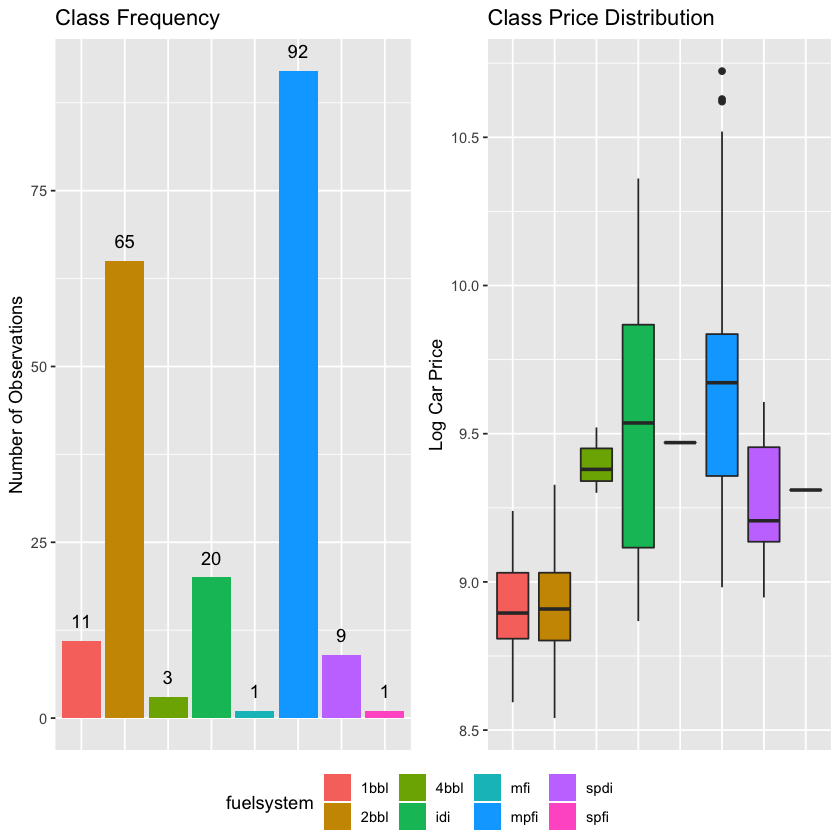

In [54]:
###### Fuel System ###########

# boxplots: visualise the distribution of car price in each plot and find the distributions that are similar
full_sys_price = ggplot(df, aes(x = fuelsystem  , y = log_price, fill = fuelsystem )) + geom_boxplot()   +
  ylab('Log Car Price')+ 
  theme(legend.position="none", axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
    ggtitle(label = "Class Price Distribution")

# frequency plot: visualise the number of observations in each class

full_sys_count = ggplot(df, aes(x = fuelsystem, fill =fuelsystem  )) + 
  geom_bar(position = "stack") +
  geom_text(stat='count', aes(label=..count..), vjust=-1)+
  ylab('Number of Observations')+ 
  theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.title.x=element_blank())+ 
  ggtitle(label = "Class Frequency")

# plots both side by side
grid_arrange_shared_legend(full_sys_count, full_sys_price)


df$fuelsystem <- fct_collapse(df$fuelsystem,
                              "bbl" = c("1bbl", "2bbl"),
)
df$fuelsystem <- fct_collapse(df$fuelsystem,
                              "idi_4bbl" = c("idi", "4bbl"),
)



# drop rare classes that can't be consolidated
df = df %>% filter(fuelsystem != "dohcv")
df = df %>% filter(fuelsystem != "spfi")
df = df %>% filter(fuelsystem != "mfi")

# drop the now unused level labels from variable definition
df$fuelsystem = drop.levels(df$fuelsystem)

#review new levels
print("New Fuel System Levels")
levels(df$fuelsystem)



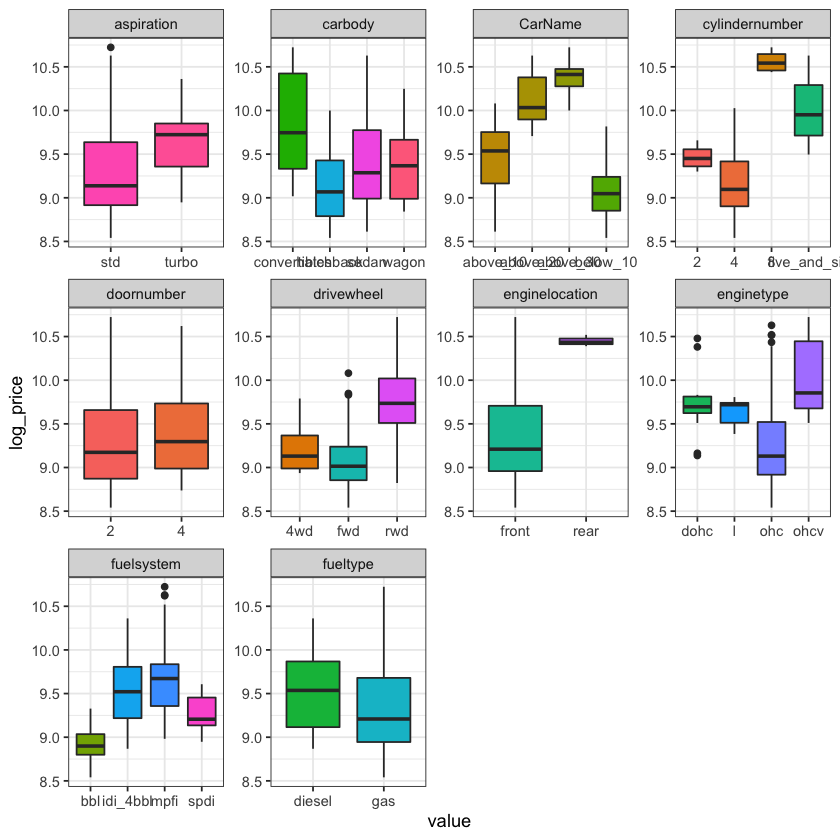

In [55]:
# create df of only categorical variables 
cat_df = select_if(df, is.factor)
cat_df['log_price'] = df['log_price']
# scatterplot of each continous variables vs log car price
a = cat_df %>%
  gather(-log_price, key = "var", value = "value") %>%
   ggplot(aes(x = value  , y = log_price, fill = value )) + geom_boxplot() +
    facet_wrap(~ var, scales = "free") +
    theme_bw() 

a + theme(legend.position="none") 

#### 3.2. Data Variable Reduction

We also address the large number of columns within the data set by examining if there are any data variables that have weak relationships with 'log car price' which we can exclude from the analysis. We examine the relationships between each covariate and 'log car price' using scatterplots for continuous variables.

It is harder to assess the relationship with the response has with each categorical variable, but we can use the above visual to spot inconsistencies in distribution of `log_price` within each class.  For example, in the the above grouped boxplots we can see that `engine location` variable has a rare class. Only a small number of observations in the data set has `engine location` of `rear` which, checking back with the data-frame printed above, are all  "Porsche" cars. We drop `engine location` columns from the dataset as the difference in engine location is explained by `car make`. We can also see that the distribution of `log_price` observations within the classes of `door_number` are almost identical. This means `door_number` does not have a strong relationship with `log_price` and can be excluded from analysis. 

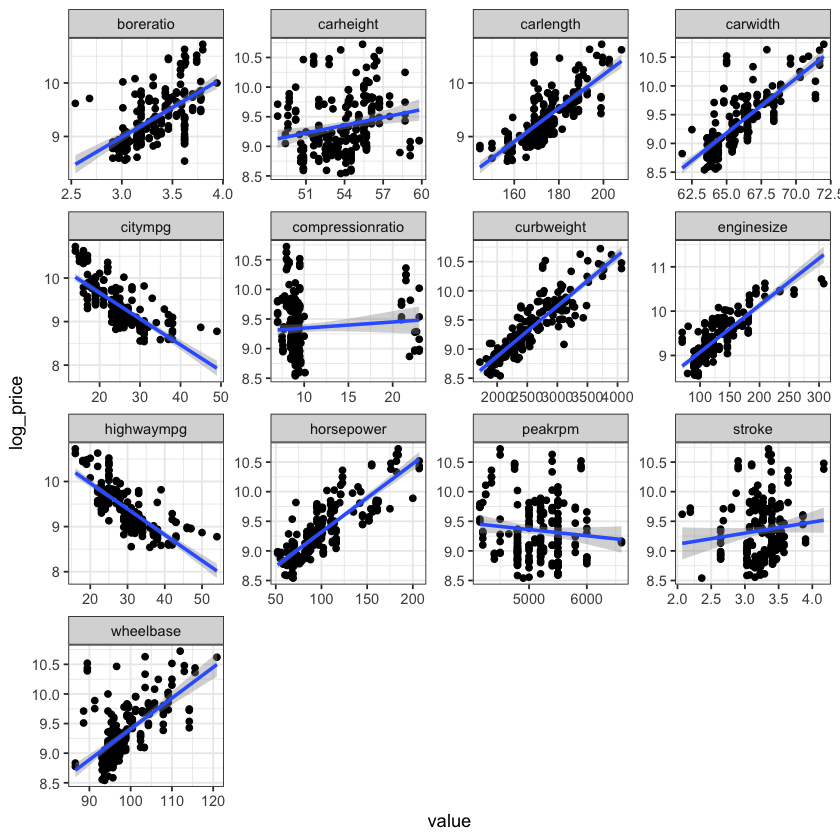

In [56]:
# create df of only continious variables 
contin_df = select_if(df, is.numeric)

# scatterplot of each continous variables vs log car price
contin_df %>%
  gather(-log_price, key = "var", value = "value") %>%
  ggplot(aes(x = value, y = log_price)) +
    geom_point() + geom_smooth(method='lm') +
    facet_wrap(~ var, scales = "free") +
    theme_bw()


We find that six variables have weak relationships with `log_price` and subsequently remove them below.

In [57]:
# table shows that rare class for engine location is only for one type of car --porche-- will drop "engine location"
engine_local_table = table(df$enginelocation, df$CarName)

# returns the column index for the variables we want to drop because no relationship with log car price
which( colnames(df)=="carheight")
which( colnames(df)=="stroke") 
which( colnames(df)=="compressionratio") 
which( colnames(df)=="peakrpm") 
which( colnames(df)=="doornumber") 
which( colnames(df)=="enginelocation") 


df = df[, -c(4,7,11,18,19,21)]

[1] 11

[1] 18

[1] 19

[1] 21

[1] 4

[1] 7

### 4. Data Modelling

#### 4.1 Model Fitting

We first split the data into training and test sets. A random 75% of the observations are selected for the training set and the remaining 25% of the dataset serves as the test set. This allows us to use the train set to build and tune the best model to then apply the test set to, as an *'unseen data'* data sample. This technique is used to measure how well the model's predictive power generalises to new data.

We fit a multiple linear regression model to the data, as the exploration mentioned above show that the relationships between `log_price` and the continuous variables when visualised, appear to be linear. The categorical variables are fit as *factor* or *dummy-variables*  which permits the response to vary with the factor variable nonlinear way. In return, each class of the factor has its own model parameter which is estimated by the model given all other class covariates are assumed to be zero.

A 4 minute clip on dummy variables can be found here: http://www.youtube.com/watch?v=s7EyQwJahgw

In [58]:
###### Split train and test ###############

smp_size <- floor(0.75 * nrow(df))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(df)), size = smp_size)

#define train (75%) and and test sets (25%)
train <- df[train_ind, ]
test <- df[-train_ind, ]

# fit model with lm() function (~ . is shorthand for all variables besides the one you put infront as response - here "log_price")
linear_all = lm(formula = log_price ~ ., data = train)
summary(linear_all)



Call:
lm(formula = log_price ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38077 -0.08060 -0.00584  0.07272  0.43165 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         6.1763966  0.8245876   7.490 1.24e-11 ***
CarNameabove_20     0.3794002  0.0764167   4.965 2.28e-06 ***
CarNameabove_30     0.2358800  0.0821722   2.871 0.004838 ** 
CarNamebelow_10    -0.0611856  0.0313732  -1.950 0.053459 .  
fueltypegas        -0.1755311  0.1701950  -1.031 0.304433    
aspirationturbo    -0.0597245  0.0527535  -1.132 0.259813    
carbodyhatchback   -0.1237859  0.0621276  -1.992 0.048573 *  
carbodysedan       -0.0673932  0.0642541  -1.049 0.296335    
carbodywagon       -0.1238951  0.0746471  -1.660 0.099556 .  
drivewheelfwd      -0.0183209  0.0765602  -0.239 0.811278    
drivewheelrwd      -0.0042211  0.0797560  -0.053 0.957879    
wheelbase           0.0041934  0.0056779   0.739 0.461620    
carlength          -0.0048

#### 4.2 Model Selection

Model selection was performed using *Automated variable selection* functions provided within the *CAR* library in *R*. This returned the set of model covariates that resulted in a model with the lowest error relative to the other possible sets. Collinearity was assessed using the *VIF()* function below. Variance inflation factors (VIFs) are based on fitting linear models between each covariate and all of the other covariates. A high VIF indicates correlated covariates.

In [59]:
# automated variable selection with combined forward and backward stepwise selection
linear_step = step(linear_all , direction = "both")

Start:  AIC=-578.78
log_price ~ CarName + fueltype + aspiration + carbody + drivewheel + 
    wheelbase + carlength + carwidth + curbweight + enginetype + 
    cylindernumber + enginesize + fuelsystem + boreratio + horsepower + 
    citympg + highwaympg

                 Df Sum of Sq    RSS     AIC
- drivewheel      2   0.00234 2.1522 -582.62
- fuelsystem      3   0.04831 2.1982 -581.45
- cylindernumber  3   0.05752 2.2074 -580.82
- boreratio       1   0.00281 2.1527 -580.59
- wheelbase       1   0.00969 2.1596 -580.11
- highwaympg      1   0.01371 2.1636 -579.83
- enginetype      3   0.07347 2.2233 -579.74
- fueltype        1   0.01890 2.1688 -579.47
- aspiration      1   0.02277 2.1726 -579.20
<none>                        2.1499 -578.78
- carlength       1   0.03252 2.1824 -578.53
- citympg         1   0.03262 2.1825 -578.52
- enginesize      1   0.05495 2.2048 -577.00
- carbody         3   0.12875 2.2786 -576.06
- carwidth        1   0.10487 2.2547 -573.64
- curbweight      1   0.2

In [60]:
# returns the formula to call of the best model it choose
linear_step$call$formula

#fit best model
linear_stepped = lm(linear_step$call$formula, data = train)

#summary of best model
summary(linear_stepped)

log_price ~ CarName + fueltype + aspiration + carbody + carwidth + 
    curbweight + enginesize + horsepower + citympg


Call:
lm(formula = linear_step$call$formula, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39227 -0.07328 -0.00899  0.06919  0.48749 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.393e+00  7.056e-01   7.644 3.42e-12 ***
CarNameabove_20   4.803e-01  6.302e-02   7.622 3.85e-12 ***
CarNameabove_30   3.386e-01  6.218e-02   5.446 2.34e-07 ***
CarNamebelow_10  -5.165e-02  2.677e-02  -1.929  0.05576 .  
fueltypegas      -1.863e-01  5.944e-02  -3.134  0.00211 ** 
aspirationturbo  -8.992e-02  3.647e-02  -2.466  0.01493 *  
carbodyhatchback -1.690e-01  5.190e-02  -3.256  0.00143 ** 
carbodysedan     -1.105e-01  5.135e-02  -2.151  0.03321 *  
carbodywagon     -1.720e-01  6.181e-02  -2.783  0.00616 ** 
carwidth          4.951e-02  1.159e-02   4.272 3.62e-05 ***
curbweight        3.644e-04  8.739e-05   4.169 5.41e-05 ***
enginesize       -2.640e-03  8.004e-04  -3.298  0.00124 ** 
horsepower        5.630e-03  8.222e-04   

#### 4.3  Model Assumption Checking 

Data samples are made up of two components:

1. Signal
2. Random noise

The signal is the set of covariate-response relationships that we are attempting to model. These represent the true population patterns or relationships. For example, if there is a true, positive linear relationship between all car engine sizes and cylinder number, then we should expect to find that relationship in the data sample signal and should be able to model it. 

Noise is the random component of the data. These are random fluctuations in measures of the variables due to random chance or error (e.g. rounding error in engine size in cm). This is considered random because there is no pattern between the differences in one sample and the next. 

*Model assumptions* are rules and limitations surrounding the statistical model used in the regression analysis. While some have to do with the capabilities of the statistical model (e.g. linear model can only model linear relationships), most assumptions are surrounding the model error or residuals. This refers to difference between the observed and predicted values of the model. We want our model to capture the data signal and leave the noise behind. This means that if we have fit our model well, then the only difference between our observed and predicted should be random noise. Model assumptions look at the distribution of the residuals to see if that's true. 

Linear Regression Model assumes the following: 

1. Linearity between the response and each covariate (specific to the conditions of linear model)
2. Normally distributed residuals
3. Constant error variance
4. Independent residuals

If all model assumptions are satisfied, the residuals should behave approximately like a random sample from a Normal distribution centred at 0. Therefore, we expect roughly 95% of standardised residuals to fall within ±2 units of zero. A histogram of standardised (scaled) compared with residuals from a Normal distribution is used to visualise this below.

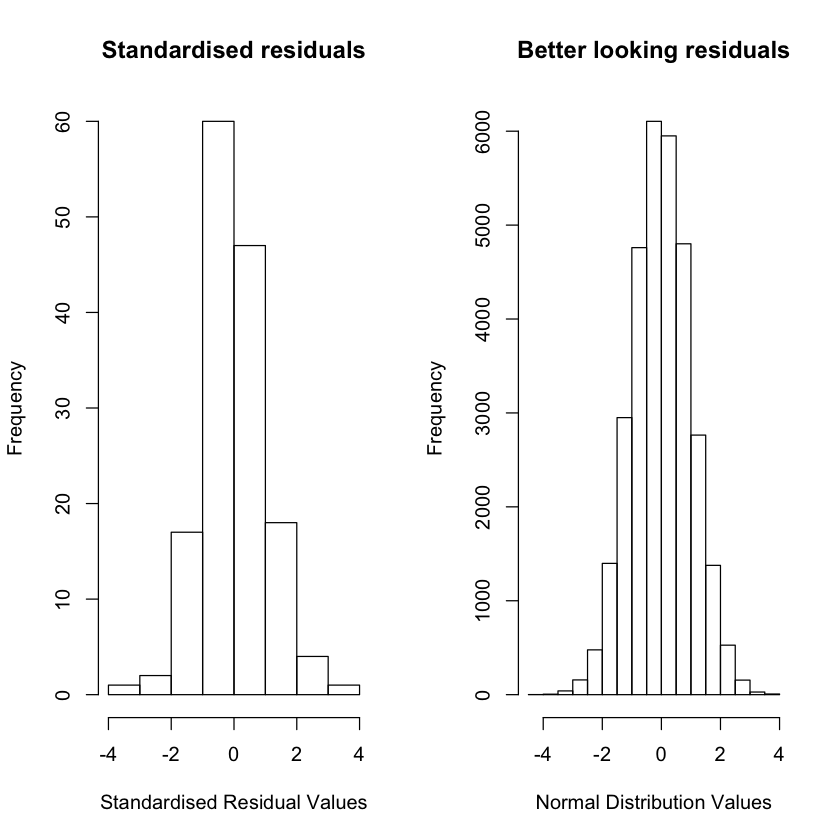

In [61]:
# sets the plotting space
par(mfrow=c(1,2))

# historgram of our standardised model residuals
hist(rstandard(linear_stepped),main="Standardised residuals", xlab="Standardised Residual Values")

# historgram of random sample from Normal dist. 
hist(rnorm(31502,0,1), main="Better looking residuals", xlab="Normal Distribution Values")


The standardised residuals have a very similar distribution to the Normal distribution on the right-hand side. From this we can be confident that our model is fit well, however we will confirm each assumption below to confirm this. 

##### 4.3.1 Linearity between the response and each covariate

If there is a non-linear relationship between a covariate and the response, the linear model would fail to describe it, and we would expect the signal (i.e. pattern) of this unmodelled relationship to be found within the model residuals. In these cases, we can plot the model residuals against the fitted values to see if any pattern exists. If only linear relationships exists then they will be captured in the model and the residuals should show pattern-less horizontal band of observations if linearity is met and there is no non-linear relationship between the covariate and response.


In [62]:
# plot of model residuals vs model fitted values for the assessment of linearity

# call 'fitted()' on model object for fitted values in array, similar for standardised residuals using rstandard() func.
plot(fitted(linear_stepped),rstandard(linear_stepped), col="darkgrey", xlab = "Model Fitted Values", ylab = "Standardised Redisual Values", main = "Residuals Vs. Fitted Values from Linear Model")

#draws a line at zero for visual help
abline(h=0)

#draws a line through our data so we can compare to zero-line
lines(lowess(fitted(linear_stepped),rstandard(linear_stepped)), col="red",lwd=2) # fits a line around zero


The plot above shows a pattern-less band of observations and suggests that the linearity assumption has been met. 

##### 4.3.2 Normally distributed residuals

A *Shapiro-Wilks* test can be used to formally test the null hypothesis that the residuals come from a Normal distribution. This test uses the same idea of comparing the percentiles of two samples to make a test statistic and for this test, large p-values provide no evidence against the Normality hypothesis. Conversely, small p-values (< 0.05) signal strong evidence of non-normality. 

In [63]:
# Formal Shapiro-Wilk test test for normality assumption
shapiro.test(residuals(linear_stepped))



	Shapiro-Wilk normality test

data:  residuals(linear_stepped)
W = 0.97262, p-value = 0.004308


The Shaprio-Wilks test above returns a p-value larger that 0.05 which indicates that the model residuals are normally distributed.

##### 4.3.3 Constant error variance

As the noise is random, there should be no change (i.e. pattern) in the variance measure of the model residuals as the response value changes. We can formally test for non-constant error variance using the *Breusch-Pagan test*. The idea behind the test is that if we have constant error variance, then the variation in the residuals should be unrelated to any of the covariates. Violation of this assumption can lead us to conclude that one or more irrelevant variables are important or that important variables should be excluded from a model. Small p-values provide evidence against the constant error variance hypothesis. 



In [64]:
# Formal Breusch-Pagan test for non-constant error variance
ncvTest(linear_stepped)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.4910819, Df = 1, p = 0.48345

The Breusch-Pagan test above confirms this assumption is met in our model, and provides strong evidence for constant error variance (the p-value is much larger than 0.05). If this assumption were to be violated, we would consider alternative regression methods that allows a departure from constant error variance such as *Generalised Least Squares models*.

##### 4.3.3 Independent Model Residuals 

When the errors are independent the residuals should resemble a random scatter of points about the horizontal axis. Clusters of successive positive or negative residuals suggest serial correlation (a relationship between successive residuals). We use the Durbin Watson test below to check this. As with other tests, small p-values (< 0.05) provide evidence against the null hypothesis and suggest we have correlated errors (i.e. dependent residuals). The test below indicates that the model residuals are independent.

In [65]:
# Formal Durbin-Watson test for Indepdent Errors
durbinWatsonTest(linear_stepped)


 lag Autocorrelation D-W Statistic p-value
   1      0.09114066      1.790034   0.192
 Alternative hypothesis: rho != 0

#### 4.4 Model Assessment 

The model is refit using the 'unseen' test data set which results in an r-squared of 93% and a Root Mean Squared Error (RMSE) of 0.15. A RMSE value less than 0.5 is generally considered as an accurate predictive model. A scatterplot of the predicted versus actual `log_price` values confirms the above measures of error. The visuals below show the best fit line through the predicted and observed values for the train (first plot) and test data set (second plot). A perfect 45-degree line indicates complete prediction accuracy. 

This shows that our model accuracy hasn't decreased for unseen data which indicates that the model's predictive power is sufficient for future samples of data. 

In [66]:
#refit the model using the test data set
preds = predict(linear_stepped, test)

# plot the observed v. fitted for train and test set
par(mfrow=c(1,2))
plot(train$log_price, fitted(linear_stepped),main="Training Set: Observed vs Fitted Values", xlab="Observed Values", ylab="Fitted values")
abline(0,1)
plot(preds, test$log_price,main="Test Set: Observed vs Fitted Values", xlab="Observed Values", ylab="Fitted values")
abline(0,1)



The model output shows many model details. We include the following aspects of the model output that we think should be focused on:

##### 1. Estimate for each coefficient: 
This is the parameter estimate for the covariate and can be thought of as the relationship estimated between the covariate and response. For example if the `engine size` estimate indicates that an increase in engine size by 1cm results in a decrease in log car price by 2.640e-03. The *intercept estimate* refers to the expected value of the response when all of the covariates are equal to zero or categorical baseline level. This value does not always have logical meaning.

##### 2. P-value for relationship significance:

T-test is performed to determine if the relationship between the covariate and response is significant (last column in output). A small p-value indicates that the covariate has a significant relationship with the response. Only covariates that have a significant relationship should be included in the model.

##### 3. Measures of error: Adjusted R-squared

Poor model performance can be due to many factors. It could be due to a failure in model type or model variable selection, or because we haven't collected the correct kind of data variables. If there is a violation of the model assumption it is likely fixed by choosing a different modeling techniques that account for the specific violations.

Model performance will also suffer if model covariates are included in the wrong way. For example, model covariates included as continuous variables when they would be better as a type of categorical covariate called *dummy-variables*. Lastly, a common issue in model performance is when relationships between the covariates exist and are not modelled correctly. 

Correlated model covariates can lead to collinearity, which can result in biased model parameter estimates and decreased predictive power. Collinearity can be addressed by removing one or more collinear covariates, or using more complex regression modelling techniques to account for the relationships like *Effect* and *Penalised* regression modelling. See the *Further Reading* section for a more in-depth look at accessing model prediction accuracy.


In [67]:
summary(linear_stepped)


Call:
lm(formula = linear_step$call$formula, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39227 -0.07328 -0.00899  0.06919  0.48749 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       5.393e+00  7.056e-01   7.644 3.42e-12 ***
CarNameabove_20   4.803e-01  6.302e-02   7.622 3.85e-12 ***
CarNameabove_30   3.386e-01  6.218e-02   5.446 2.34e-07 ***
CarNamebelow_10  -5.165e-02  2.677e-02  -1.929  0.05576 .  
fueltypegas      -1.863e-01  5.944e-02  -3.134  0.00211 ** 
aspirationturbo  -8.992e-02  3.647e-02  -2.466  0.01493 *  
carbodyhatchback -1.690e-01  5.190e-02  -3.256  0.00143 ** 
carbodysedan     -1.105e-01  5.135e-02  -2.151  0.03321 *  
carbodywagon     -1.720e-01  6.181e-02  -2.783  0.00616 ** 
carwidth          4.951e-02  1.159e-02   4.272 3.62e-05 ***
curbweight        3.644e-04  8.739e-05   4.169 5.41e-05 ***
enginesize       -2.640e-03  8.004e-04  -3.298  0.00124 ** 
horsepower        5.630e-03  8.222e-04   